# **Proyecto 3: Filtros**

### Andres Banquez- Melina Villada

## **Objetivos:**

Implementar un flujo de procesamiento que incluya filtrado de las señales y extracción de características espectrales


1. Del artículo:
https://www.nature.com/articles/s41598-020-59821-7

Consultar y explicar los dos métodos de reducción de ruido usados en el artículo: Robust LOESS y Non Local Means (10%), mostrar cómo se podrían implementar en Python (5%)

**Robust LOESS (Locally Estimated Scatterplot Smoothing)**: Este método elimina el ruido de baja frecuencia, como el "baseline wandering", que ocurre debido a movimientos respiratorios o variaciones en la posición del electrodo. LOESS realiza un ajuste local ponderado de polinomios en cada punto de la señal, eliminando las fluctuaciones lentas en el nivel de la señal manteniendo las características de alta frecuencia.

El término “loess” es un acrónimo de “regresión local” y todo el procedimiento es una generalización bastante directa de los métodos tradicionales de mínimos cuadrados para el análisis de datos. El loess es no paramétrico en el sentido de que la técnica de ajuste no requiere una especificación a priori de la relación entre las variables dependientes e independientes.[1]



In [2]:
import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess
import matplotlib.pyplot as plt
from skimage.restoration import denoise_nl_means, estimate_sigma
import pywt
import pandas as pd
import os
import shutil

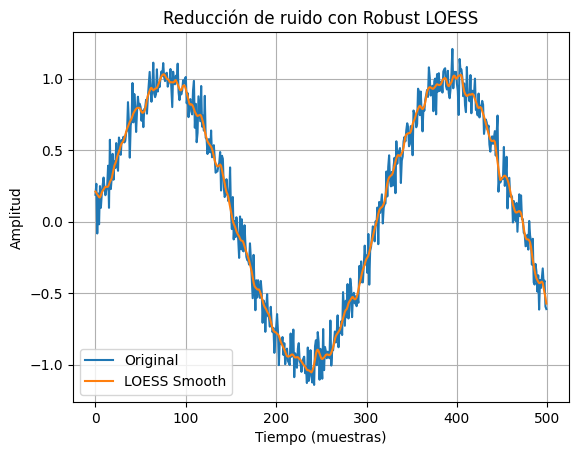

In [3]:
# Ejemplo con una señal ficticia de ECG
ecg_signal = np.sin(np.linspace(0, 10, 500)) + np.random.normal(0, 0.1, 500)
smoothed_signal = lowess(ecg_signal, np.arange(len(ecg_signal)), frac=0.02, is_sorted=True)

# Graficar señal original y suavizada

plt.plot(ecg_signal, label='Original')
plt.plot(smoothed_signal[:, 1], label='LOESS Smooth')
plt.xlabel("Tiempo (muestras)")
plt.ylabel("Amplitud")
plt.title("Reducción de ruido con Robust LOESS")
plt.grid()
plt.legend()
plt.show()


**Non-Local Means (NLM):** Este método se utiliza principalmente para eliminar el ruido de alta frecuencia manteniendo estructuras repetitivas de la señal. Calcula el promedio ponderado de puntos similares dentro de una ventana para cada punto, basado en un parámetro de similitud. Esto preserva detalles como picos característicos de la señal ECG.

El método no local (NLM) es un método reciente de eliminación de ruido que ha recibido mucha atención de la comunidad de procesamiento de señales. Mientras que el filtrado lineal estándar se basa en la correlación espacial local, el principio no local explota el hecho de que pueden aparecer vecindarios similares en cualquier parte de la imagen ypueden contribuir a la eliminación de ruido. [2]



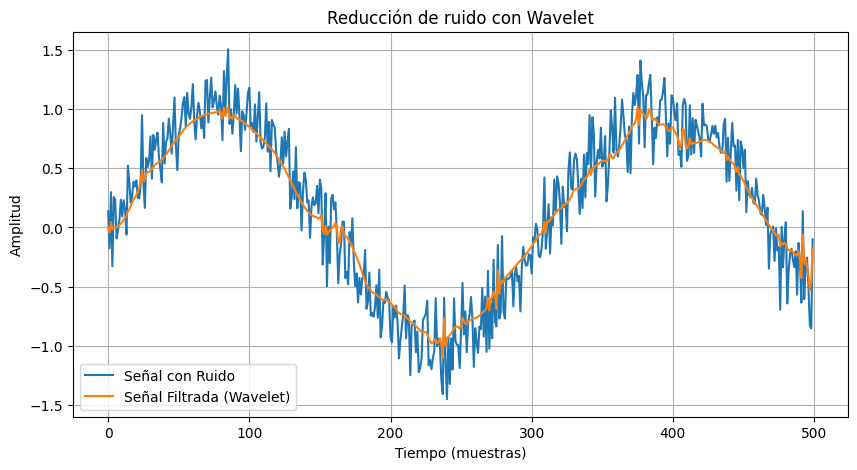

In [4]:


# Señal de ejemplo con ruido
noisy_ecg_signal = np.sin(np.linspace(0, 10, 500)) + np.random.normal(0, 0.2, 500)

# Descomposición en wavelets
coeffs = pywt.wavedec(noisy_ecg_signal, 'db4', level=4)

# Umbralizado de los coeficientes
threshold = np.std(noisy_ecg_signal) / 2
coeffs = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]

# Reconstrucción de la señal filtrada
denoised_signal = pywt.waverec(coeffs, 'db4')

# Graficar señal original y denoised
plt.figure(figsize=(10, 5))
plt.plot(noisy_ecg_signal, label='Señal con Ruido')
plt.plot(denoised_signal, label='Señal Filtrada (Wavelet)')
plt.xlabel("Tiempo (muestras)")
plt.ylabel("Amplitud")
plt.title("Reducción de ruido con Wavelet")
plt.legend()
plt.grid()
plt.show()







2. Descargar los datos ECGData.zip de:
https://figshare.com/collections/ChapmanECG/4560497/1

De la base de datos extraer los registros que correspondan a bradicardia sinusal (SB Sinus Bradycardia) y fibrilación auricular (AFIB Atrial Fibrillation). Esta información está en el archivo Diagnostics.xlsx

In [5]:
diagnostics_path = 'Diagnostics.xlsx'
diagnostics_df = pd.read_excel(diagnostics_path)
sbyafib_df=diagnostics_df[diagnostics_df['Rhythm'].isin(['AFIB', 'SB'])]
needed_files = sbyafib_df['FileName'].tolist()

In [6]:
data_folder = r"D:\Descargas\ECGData\ECGData"
destination_folder = r"D:\Descargas\ECGData\Derivacion_II_Filtrados"
os.makedirs(destination_folder, exist_ok=True)

for file_name in needed_files:
    source_path = os.path.join(data_folder, f"{file_name}.csv") 
    
    if os.path.exists(source_path):
        # Cargar el archivo CSV
        ecg_data = pd.read_csv(source_path)
        
        
        if 'II' in ecg_data.columns:
            derivacion_II = ecg_data['II']
            save_path = os.path.join(destination_folder, f"{file_name}_derivacion_II.csv")
            derivacion_II.to_csv(save_path, index=False)
            print(f"Derivación II extraída y guardada para: {file_name}.csv")
        else:
            print(f"Columna 'Derivacion_II' no encontrada en el archivo: {file_name}.csv")
    else:
        print(f"Archivo no encontrado: {file_name}.csv")



Derivación II extraída y guardada para: MUSE_20180113_171327_27000.csv
Derivación II extraída y guardada para: MUSE_20180112_073319_29000.csv
Derivación II extraída y guardada para: MUSE_20180113_121940_44000.csv
Derivación II extraída y guardada para: MUSE_20180112_120347_79000.csv
Derivación II extraída y guardada para: MUSE_20180114_075026_69000.csv
Derivación II extraída y guardada para: MUSE_20180114_075128_92000.csv
Derivación II extraída y guardada para: MUSE_20180118_174026_42000.csv
Derivación II extraída y guardada para: MUSE_20180115_125443_25000.csv
Derivación II extraída y guardada para: MUSE_20180113_134825_04000.csv
Derivación II extraída y guardada para: MUSE_20180114_070718_20000.csv
Derivación II extraída y guardada para: MUSE_20180115_133559_70000.csv
Derivación II extraída y guardada para: MUSE_20180113_133901_16000.csv
Derivación II extraída y guardada para: MUSE_20180113_071734_35000.csv
Derivación II extraída y guardada para: MUSE_20180114_121218_64000.csv
Deriva

3. Consultar que otros tipos de señales wavelet se pueden usar para el análisis de señales ECG y adaptar el código del filtro wavelet que se entrega en el curso de acuerdo a la consulta (10%)

Para el análisis de señales ECG, se pueden emplear varias familias de wavelets adicionales, cada una con características específicas que pueden mejorar la extracción de información en distintos aspectos de la señal. Algunas opciones incluyen:

Wavelet de Daubechies (db): Esta familia es popular para ECG por su suavidad y sus similitudes con las características de la señal, especialmente las versiones como db4, db6, y db8.

Wavelet de Symlet (sym): Ofrece mejor simetría y es adecuada para detectar transitorios y componentes de baja frecuencia en ECG. Ejemplos útiles son sym4 y sym8.

Wavelet de Coiflet (coif): Ideal para captar detalles en señales que tienen estructuras complejas en el dominio del tiempo-frecuencia, como coif3 y coif5.

Wavelet de Biorthogonal (bior): Útil para análisis multi-resolución en ECG, ya que mantiene buena precisión en los bordes y puede capturar transiciones bruscas.

4. Escoger 10 señales al azar y aplicar un flujo de procesamiento que conste de:

Flujo 1

1. Filtro pasa-altas usando filtro IIR a 0.5 Hz. Justificar la elección de parámetros y si se usa FIR o IIR
2. Filtro wavelet modificado del punto 3
3. Filtrado pasabajas 50 Hz. Justificar la elección de parámetros y si se usa FIR o IIR

Flujo 2

1. Detrend
2. Filtro wavelet modificado del punto 3
3. Filtrado pasabajas 50 Hz. Justificar la elección de parámetros y si se usa FIR o IIR

Flujo 3

1. Filtro pasa-altas usando filtro IIR a 0.5 Hz. Justificar la elección de parámetros y si se usa FIR o IIR
2. Filtrado pasabajas 50 Hz. Justificar la elección de parámetros y si se usa FIR o IIR

Describir los resultados obtenidos y decidir si el resto del procesamiento se hace con el flujo 1, el flujo 2 o el flujo 3 (20%)

Con el flujo seleccionado procesar las señales de la base de datos ECGData.zip derivación II. En este punto deberíamos estar en el mismo punto donde partimos en el proyecto 2, con señales filtradas.

A las señales filtradas con el flujo seleccionado aplicar el procesamiento de normalización usado en el proyecto 2.

In [24]:
directory = r'D:\Descargas\ECGData\Derivacion_II_Filtrados'

output_directory = r'Derivacion_II_Filtrados'
os.makedirs(output_directory, exist_ok=True)

existing_files = [f for f in os.listdir(output_directory) if f.endswith('.csv')]
if len(existing_files) >= 10:
    print("Ya existen 10 o más archivos CSV en el directorio de destino. No se realizará una nueva selección.")
else:
    # Obtener una lista de todos los archivos CSV en el directorio de entrada
    csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]

# Seleccionar aleatoriamente 10 archivos CSV
    selected_files = np.random.choice(csv_files, 10, replace=False)

# Copiar los archivos seleccionados al directorio de destino
    for file in selected_files:
        source_path = os.path.join(directory, file)
        destination_path = os.path.join(output_directory, file)
        shutil.copy(source_path, destination_path)

    print("Se han seleccionado y copiado 10 archivos CSV aleatoriamente.")


Ya existen 10 o más archivos CSV en el directorio de destino. No se realizará una nueva selección.


5. Para cada señal extraer la frecuencia que contiene la máxima potencia usando Welch (15%)

6. Crear una rutina que aplique sobre todos los archivos de la base de datos las rutina 3 al 5 y almacene los resultados en un dataframe donde se pueda registro, tipo de patología y el frecuencia de máxima potencia (fMP):

7. Comparar los resultados de fMP del proyecto 3 con los del proyecto 2 usando estadística descriptiva: gráficos y pruebas de hipótesis (15%) Discuta si hay más diferencias entre los tipos de señales con el flujo de procesamiento propuesto respecto al que se trabajó en el proyecto 2.

8. Hacer un informe con todos los puntos anteriores (15%)

## **Bibliografía**


[1] Oh, H.-S., Nychka, D., Brown, T., & Charbonneau, P. (2004). Period analysis of variable stars by robust smoothing. Journal of the Royal Statistical Society. Series C, Applied Statistics, 53(1), 15–30. https://doi.org/10.1111/j.1467-9876.2004.00423.x

[2] Van De Ville, D., & Kocher, M. (2009). SURE-Based Non-Local Means. IEEE signal processing letters, 16(11), 973–976. https://doi.org/10.1109/lsp.2009.2027669

